# P-values for simple binned cut-and-count experiments

Here, we perform a simple cut and count experiment, drawing data from a 2D Gaussian. Binning the distributions we calculate the expectation value per pin using the pdf of the distribution (i.e. oversampling infinitely) and use Poisson statistics to obtain the significance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

First we define some helper functions including one generating the data, one calculating p-values from significances and one (with its own helper function) calculating the significances themselves using the Asimov estimate.

In [3]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(sig))

def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    #a = 1-stats.nbinom.cdf(N_BT-1, N_data, k)
    #b = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    #inds = np.where(N_data>N_BT, 0, 1)
    #return inds*a +(1-inds)*b

    #if N_data < N_BT:
    #    return 1-stats.nbinom.cdf(N_BT-1, N_data, k)
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_value_poisson(N_data, N_BT):
    return 1-stats.poisson.cdf(N_data-1, N_BT)

def p_value_binomial(N_data, N_BT, N_total):
    return 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)

def sig(N, b, err):
    """
    Complicated significance formula calculation where N=N_obs, b = N_exp and err=delta_sys
    """
    if err==0:
        s=N-b
        x=N*np.log(1+s/b)-s
        x[x<0]=0
        return np.sqrt(2*(x))
    s = N - b
    ln1 = N * (b+err**2) / (b**2+N*err**2)
    ln1 = 2 * N * np.log(ln1)

    ln2 = 1 + err**2 * s / b / (b+err**2)
    ln2 = 2 * b**2 / err**2 * np.log(ln2)
    x = ln1 - ln2
    x[x<0]=0
    return np.sqrt(x)

def significance_formula(N_data, N_BT):
    return sig(N_data, N_BT, 0)

def significance_naive(N_data, N_BT):
    return (N_data-N_BT)/np.sqrt(N_BT)

In [4]:
def do_test(N_tests, bins, N, bins_edge = None):
    rv = multivariate_normal([0,0], [[1,0],[0,1]])
    if bins_edge is None:
        edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
    else:
        edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

    exp = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

    p_poisson = np.zeros((bins,bins, N_tests))
    p_binomial = np.zeros((bins,bins, N_tests))
    for k in tqdm.tqdm(range(N_tests)):
        data = rv.rvs(size=N, random_state=k)
        hist = np.histogramdd(data, bins=edges)[0]
        p_poisson[:,:, k] = p_value_poisson(hist, exp)
        p_binomial[:,:,k] = p_value_binomial(hist, exp, N)
    return p_poisson, p_binomial       

100%|██████████| 100000/100000 [03:55<00:00, 425.20it/s]


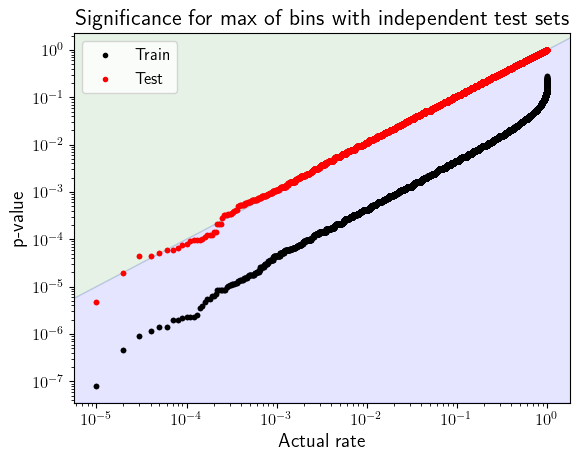

In [19]:
def do_test_independent_test(N_tests, bins, N, bins_edge = None):
    rv = multivariate_normal([0,0], [[1,0],[0,1]])
    if bins_edge is None:
        edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
    else:
        edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

    exp = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

    #p_poisson = np.zeros((bins,bins, N_tests))
    p_binomial = np.zeros((bins,bins, N_tests))
    p_binomial2 = np.zeros((bins,bins, N_tests))
    for k in tqdm.tqdm(range(N_tests)):
        data = rv.rvs(size=N, random_state=k)
        hist = np.histogramdd(data, bins=edges)[0]
        #p_poisson[:,:, k] = p_value_poisson(hist, exp)
        p_binomial[:,:,k] = p_value_binomial(hist, exp, N)

        data = rv.rvs(size=N, random_state=N_tests+k)
        hist = np.histogramdd(data, bins=edges)[0]
        #p_poisson[:,:, k] = p_value_poisson(hist, exp)
        p_binomial2[:,:,k] = p_value_binomial(hist, exp, N)
    return p_binomial, p_binomial2   

bins = 5
N_tests = 100000
N = 10000
bins_edge = 2
p_binomial, p_binomial2 = do_test_independent_test(N_tests, bins, N, bins_edge = bins_edge)

#Plot for max of bins
plt.figure()
plt.title("Significance for max of bins with independent test sets")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

trials = N_tests
counts = np.arange(1, trials+1)

min_ind = np.argmin(p_binomial.reshape((bins*bins, N_tests)), axis=0)
p1 = [p_binomial.reshape((bins*bins,N_tests))[min_ind[i],i] for i in range(N_tests)]
p2 = [p_binomial2.reshape((bins*bins,N_tests))[min_ind[i],i] for i in range(N_tests)]
plt.scatter(counts/trials, np.sort(p1), marker = '.', color="black")
plt.scatter(counts/trials, np.sort(p2), marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.scatter(counts/trials, np.sort(p1), marker = '.', color="black", label="Train")
plt.scatter(counts/trials, np.sort(p2), marker = '.', color="red", label="Test")
plt.legend()
plt.savefig("plots/binomial_poisson/maxbins_binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

In [5]:
def do_test_kfold(N_tests, bins, N, bins_edge = None, folds=5):
    rv = multivariate_normal([0,0], [[1,0],[0,1]])
    if bins_edge is None:
        edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
    else:
        edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

    exp = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

    #p_poisson = np.zeros((bins,bins, N_tests))
    p_test = np.zeros((N_tests, folds))
    p_global = np.zeros((N_tests))
    p_add = np.zeros((N_tests))
    p_train = np.zeros((N_tests, bins*bins, folds))
    for k in tqdm.tqdm(range(N_tests)):
        hist = np.zeros((bins,bins, folds))
        N_test = np.zeros((folds))
        exp_test = np.zeros((folds))
        best_bin = np.zeros((folds), dtype=int)
        data = np.array_split(rv.rvs(size=N, random_state=k), folds)
        for m in range(folds):
            hist[:,:,m] = np.histogramdd(data[m], bins=edges)[0]

        for m in range(folds):
            inds = np.roll(np.array(range(folds)), m)
            p_train[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[:-1]],axis=-1), exp*(folds-1)/folds, N*(folds-1)/folds).flatten()
            best_bin[m] = np.argmin(p_train[k, :,m])
            N_test[m] = hist[:,:,inds[-1]].flatten()[best_bin[m]]
            exp_test[m] = exp.flatten()[best_bin[m]]/5
            p_test[k,m] = p_value_binomial(hist.reshape((bins*bins,folds))[best_bin[m],inds[-1]], exp.flatten()[best_bin[m]]/folds, N/folds)
            
        #print(np.sum(N_test), np.sum(exp_test))
        p_add[k] = p_value_binomial(np.sum(N_test), np.sum(exp_test), N)
        p_global[k] = 1-stats.chi2.cdf(-2*np.sum(np.log(p_test[k])), 2*folds)

    return p_test, p_global, p_add, p_train

bins = 5

100%|██████████| 1000/1000 [00:19<00:00, 50.59it/s]


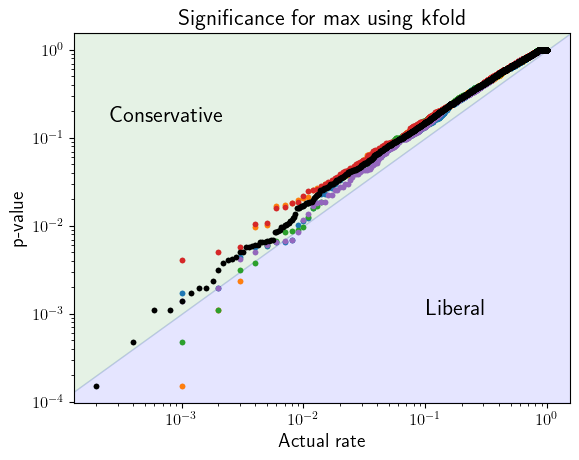

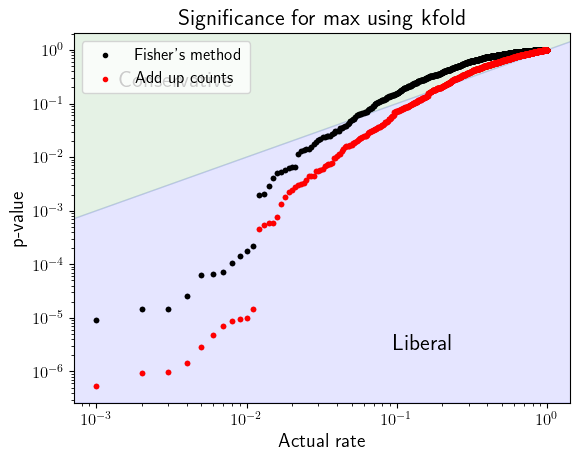

In [8]:

bins = 75
N_tests = 1000
N = 100000
bins_edge = 2
folds = 5
p_kfold, p_global, p_add, _ = do_test_kfold(N_tests, bins, N, bins_edge = bins_edge)

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
counts2 = np.arange(1, N_tests*5+1)
#print(p_kfold.flatten().shape, counts2.shape)
plt.scatter(counts2/N_tests/5, np.sort(p_kfold.flatten()), marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
plt.scatter(counts2/N_tests/5, np.sort(p_kfold.flatten()), marker = '.', color="black")
#plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black")
plt.scatter(counts/N_tests, np.sort(p_add), marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black", label="Fisher's method")
plt.scatter(counts/N_tests, np.sort(p_add), marker = '.', color="red", label="Add up counts")
plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")


100%|██████████| 1000/1000 [00:02<00:00, 413.71it/s]


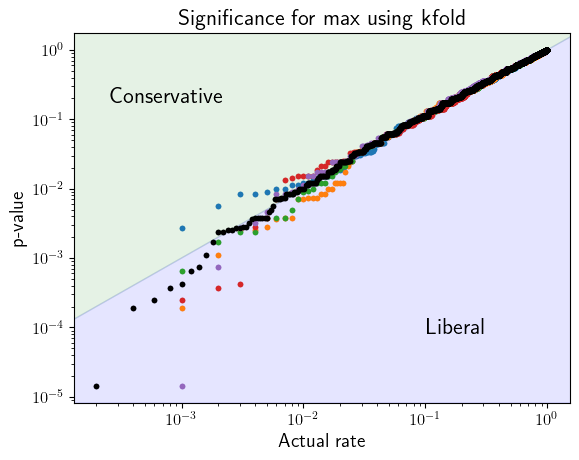

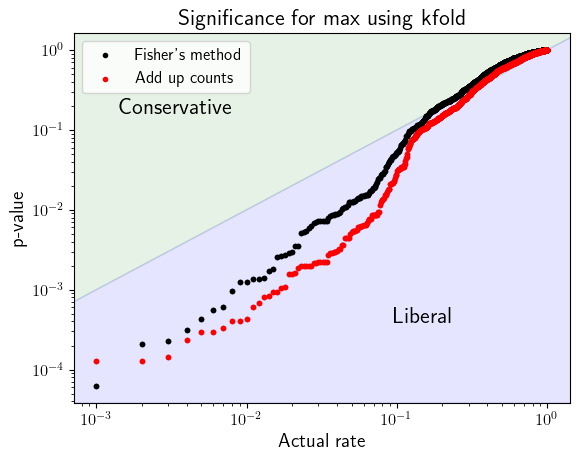

In [ ]:

bins = 5
N_tests = 1000
N = 10000
bins_edge = 2
folds = 5
p_kfold, p_global, p_add, _ = do_test_kfold(N_tests, bins, N, bins_edge = bins_edge)

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
counts2 = np.arange(1, N_tests*5+1)
#print(p_kfold.flatten().shape, counts2.shape)
plt.scatter(counts2/N_tests/5, np.sort(p_kfold.flatten()), marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
plt.scatter(counts2/N_tests/5, np.sort(p_kfold.flatten()), marker = '.', color="black")
#plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black")
plt.scatter(counts/N_tests, np.sort(p_add), marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black", label="Fisher's method")
plt.scatter(counts/N_tests, np.sort(p_add), marker = '.', color="red", label="Add up counts")
plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")


100%|██████████| 1000/1000 [00:02<00:00, 362.96it/s]


Text(0.5, 0, 'p-value fold 2')

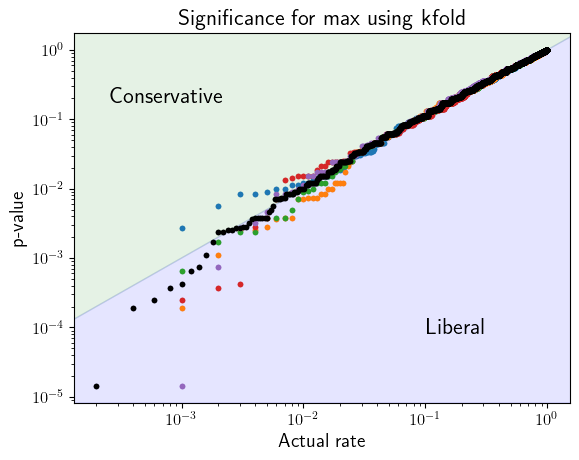

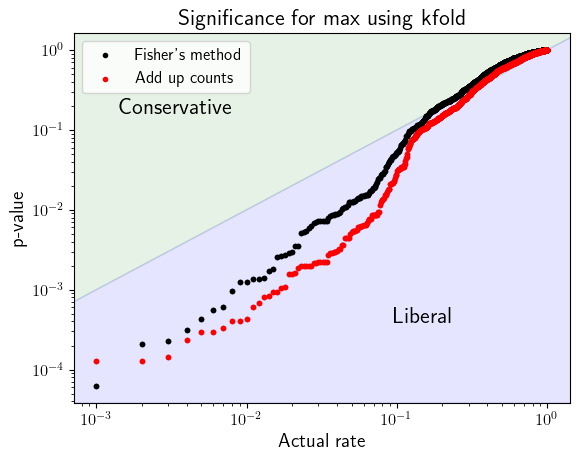

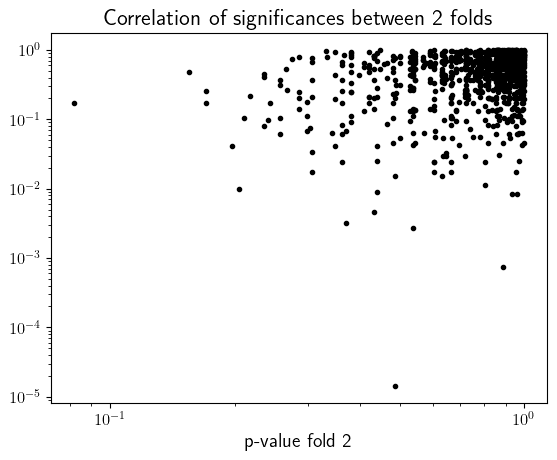

In [24]:
bins = 5
N_tests = 1000
N = 10000
bins_edge = 2
folds = 5
p_kfold, p_global, p_add, p_train = do_test_kfold(N_tests, bins, N, bins_edge = bins_edge)

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
counts2 = np.arange(1, N_tests*5+1)
#print(p_kfold.flatten().shape, counts2.shape)
plt.scatter(counts2/N_tests/5, np.sort(p_kfold.flatten()), marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
plt.scatter(counts2/N_tests/5, np.sort(p_kfold.flatten()), marker = '.', color="black")
#plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black")
plt.scatter(counts/N_tests, np.sort(p_add), marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black", label="Fisher's method")
plt.scatter(counts/N_tests, np.sort(p_add), marker = '.', color="red", label="Add up counts")
plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

plt.figure()
plt.title("Correlation of significances between 2 folds")
plt.scatter(np.max(p_kfold[:,:-1], axis=-1), p_kfold[:,-1], color="black", marker=".")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("p-value fold 1")
plt.xlabel("p-value fold 2")


100%|██████████| 100000/100000 [02:47<00:00, 597.78it/s]


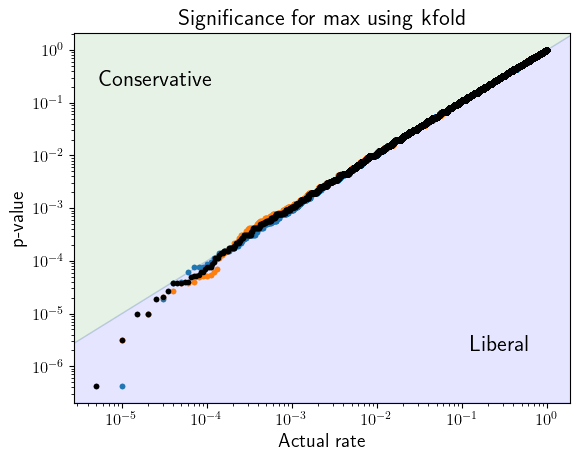

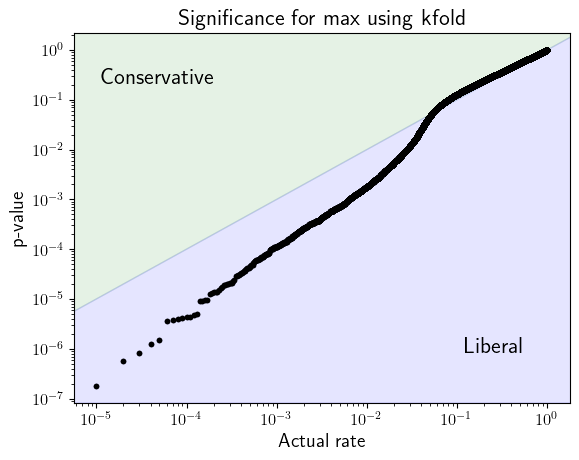

In [19]:
bins=5
N_tests = 100000
N = 10000
bins_edge = 2
folds = 2
p_kfold, p_global = do_test_kfold(N_tests, bins, N, bins_edge = bins_edge, folds=folds)

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
counts2 = np.arange(1, N_tests*folds+1)
#print(p_kfold.flatten().shape, counts2.shape)
plt.scatter(counts2/N_tests/folds, np.sort(p_kfold.flatten()), marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
plt.scatter(counts2/N_tests/folds, np.sort(p_kfold.flatten()), marker = '.', color="black")
#plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black")
#plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

100%|██████████| 100000/100000 [09:03<00:00, 183.85it/s]


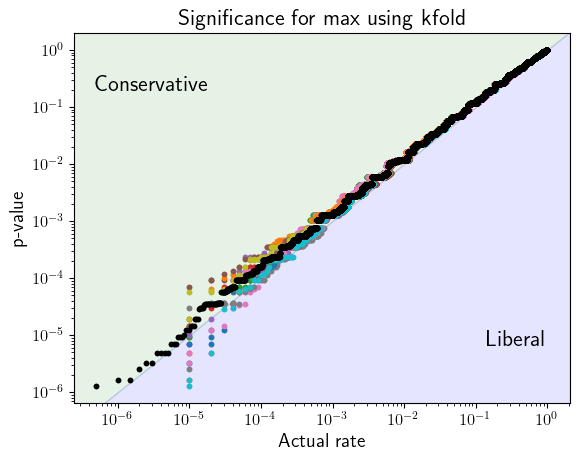

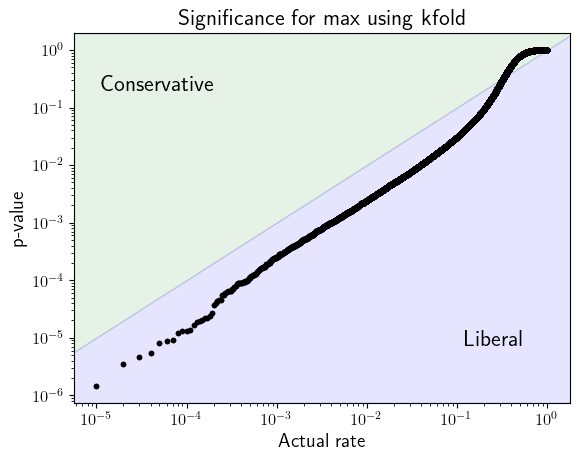

In [18]:
bins=5
N_tests = 100000
N = 10000
bins_edge = 2
folds = 20
p_kfold, p_global = do_test_kfold(N_tests, bins, N, bins_edge = bins_edge, folds=folds)

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
counts2 = np.arange(1, N_tests*folds+1)
#print(p_kfold.flatten().shape, counts2.shape)
plt.scatter(counts2/N_tests/folds, np.sort(p_kfold.flatten()), marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
for i in range(folds):
    plt.scatter(counts/N_tests, np.sort(p_kfold[:,i]), marker = '.', color="C"+str(i))
plt.scatter(counts2/N_tests/folds, np.sort(p_kfold.flatten()), marker = '.', color="black")
#plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for max using kfold")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/N_tests, np.sort(p_global), marker = '.', color="black")
#plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

In [ ]:
bins = 5
N_tests = 100000
N = 10000
bins_edge = 2
p_poisson, p_binomial = do_test(N_tests, bins, N, bins_edge = bins_edge)

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for central bin")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

plt.scatter(counts/N_tests, np.sort(p_poisson[bin_plot, bin_plot]), marker = '.', color="black")
plt.scatter(counts/N_tests, np.sort(p_binomial[bin_plot, bin_plot]), marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/N_tests, np.sort(p_poisson[bin_plot, bin_plot]), marker = '.', color="black", label="Poisson")
plt.scatter(counts/N_tests, np.sort(p_binomial[bin_plot, bin_plot]), marker = '.', color="red", label="Binomial")
plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")


#Plot for all bins
plt.figure()
plt.title("Significance for all bins")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")


trials = N_tests*bins*bins
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, np.sort(p_poisson.flatten()), marker = '.', color="black")
plt.scatter(counts/trials, np.sort(p_binomial.flatten()), marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.scatter(counts/trials, np.sort(p_poisson.flatten()), marker = '.', color="black", label="Poisson")
plt.scatter(counts/trials, np.sort(p_binomial.flatten()), marker = '.', color="red", label="Binomial")
plt.legend()
plt.savefig("plots/binomial_poisson/allbins_binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")


#Plot for max of bins
plt.figure()
plt.title("Significance for max of bins (Bonferroni correction)")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

trials = N_tests
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, np.sort(np.min(p_poisson, axis=(0,1)))*bins*bins, marker = '.', color="black")
plt.scatter(counts/trials, np.sort(np.min(p_binomial, axis=(0,1)))*bins*bins, marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.scatter(counts/trials, np.sort(np.min(p_poisson, axis=(0,1)))*bins*bins, marker = '.', color="black", label="Poisson")
plt.scatter(counts/trials, np.sort(np.min(p_binomial, axis=(0,1)))*bins*bins, marker = '.', color="red", label="Binomial")
plt.legend()
plt.savefig("plots/binomial_poisson/maxbins_binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

We then perform a number of tests $N_\text{tests}$ using $N$ datapoints collected in a certain number of bins. For the sake of computation time, we use a fixed binning so that the expectation only needs to be calculated once. Then data is drawn $N_\text{tests}$ times and the significances per bin are calculated with the binning fixed above.  

To check whether the p-values are correctly calibrated, we then calculate the observed probability of each significance $\mathcal{S_i}$ (number of occurences of $\mathcal{S}\ge\mathcal{S_i}$) and compare with the nominal p-value. 

We first do this for a single bin to check the general calculation.

Treating every bin as an independent test, we then do the same with the flattened array of all significances. 